# Ideas

1. CNN with dropout
1. Logistic regression, remember to normalize. I think it doesn't make sense to try linear regression at all. Because arbitrary boundries
1. Gaussian NB likes categorical variables so it's bad with categorical vars

```python
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
import time

warnings.simplefilter(action='ignore', category=FutureWarning)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=30027)


models = [DummyClassifier(strategy='most_frequent'),
          GaussianNB(),
          MultinomialNB(),
          svm.LinearSVC(),
          DecisionTreeClassifier(),
          KNeighborsClassifier(), # When the n_neighbors parameter is not set in the KNeighborsClassifier() function, its default value is set to 5
          LogisticRegression(max_iter = 1000)]
titles = ['Zero-R',
          'GNB',
          'MNB',
          'LinearSVC',
          'Decision Tree',
          'KNN',
          'Logistic Regression']

for title, model in zip(titles, models):
    model.fit(X_train,y_train)
    start = time.time()
    acc = model.score(X_test, y_test)
    end = time.time()
    t = end - start
    print(title, "Accuracy:",acc, 'Time:', t)

```

For cross validation:
```python

from sklearn.model_selection import cross_val_score

for title, model in zip(titles, models):
    start = time.time()
    acc = model.score(X_test, y_test)
    end = time.time()
    t = end - start
    print(title, "Accuracy:",acc, 'time:', t)
```

## Initial setup

In [289]:
import pandas as pd
import numpy as np

train_meta = pd.read_csv("./train/train_metadata.csv")
train_add_features = pd.read_csv("./train/features/additional_features.csv")
train_color_hist = pd.read_csv("./train/features/color_histogram.csv")
train_hog_pca = pd.read_csv("./train/features/hog_pca.csv")


test_meta = pd.read_csv("./test/test_metadata.csv")
test_meta.drop("ClassId", inplace=True, axis=1) # useless for now
test_add_features = pd.read_csv("./test/features/additional_features.csv")
test_color_hist = pd.read_csv("./test/features/color_histogram.csv")
test_hog_pca = pd.read_csv("./test/features/hog_pca.csv")

In [290]:
# merging all the dataframes

train_df = pd.merge(train_meta, train_add_features)
train_df = pd.merge(train_df, train_color_hist)
train_df = pd.merge(train_df, train_hog_pca)

test_df = pd.merge(test_meta, test_add_features)
test_df = pd.merge(test_df, test_color_hist)
test_df = pd.merge(test_df, test_hog_pca)


# this is just better for reading files
train_df["image_path"] = train_df["image_path"].apply(lambda x : "train/" + x)
test_df["image_path"] = test_df["image_path"].apply(lambda x : "test/" + x)

# Initial Exploration

In [291]:
# Each class is represented at least once in the test data
set(train_df["ClassId"].unique()).difference(set(range(0, 43)))

set()

In [292]:
print(np.any(train_df.isna().sum() != 0)) # no missing values
print(np.any(test_df.isna().sum() != 0)) # no missing values

False
False


Text(0, 0.5, 'Frequency')

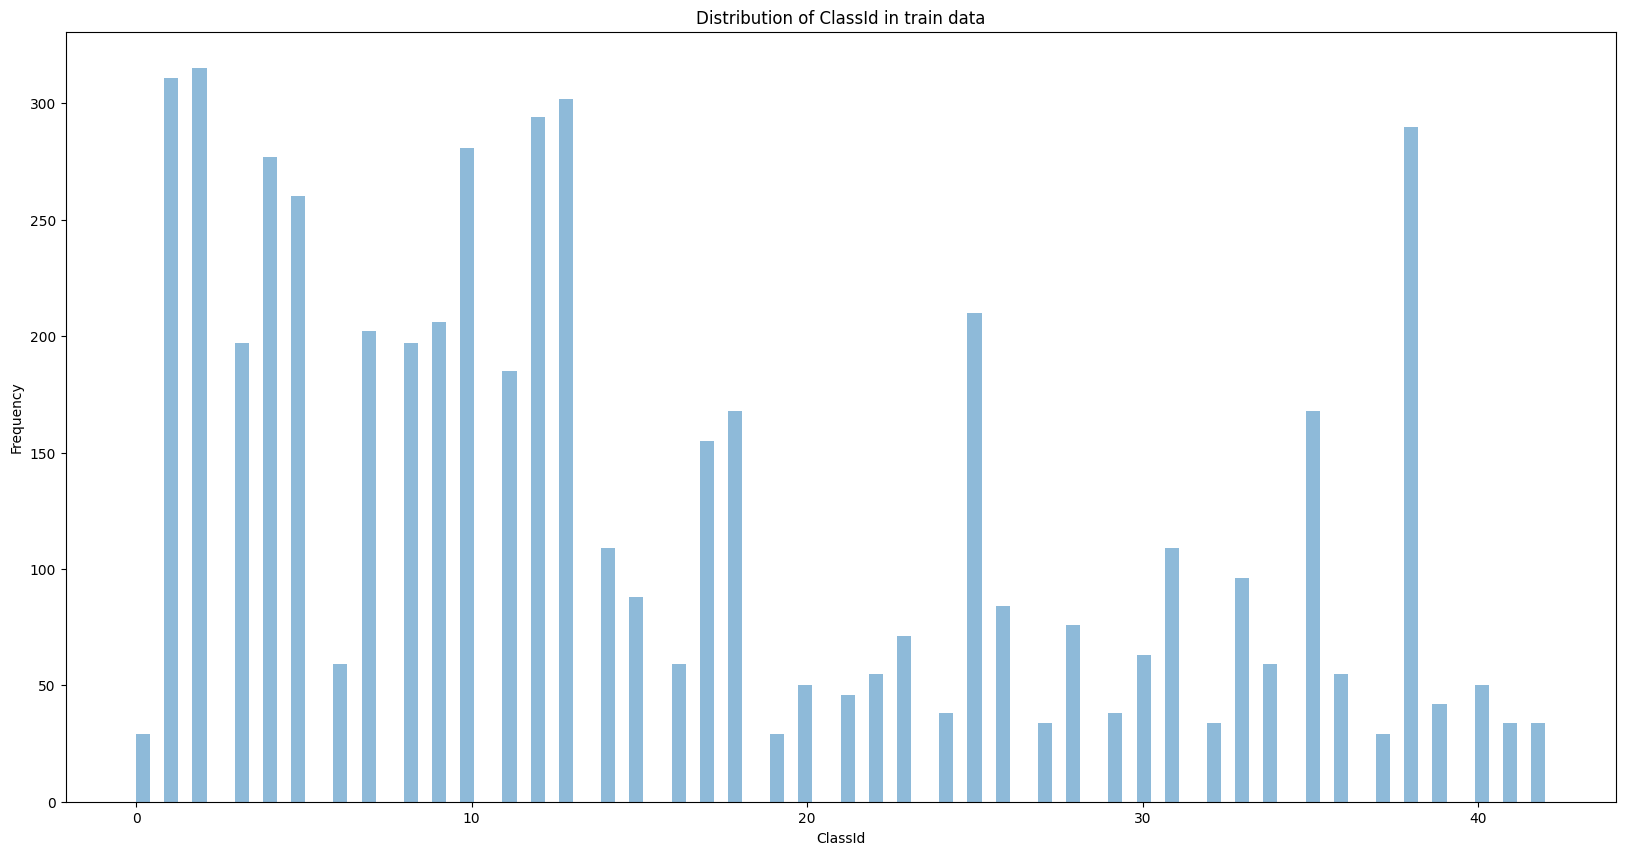

In [293]:
# do the same for test data?
import matplotlib.pyplot as plt
# lets look at the distribution of the test data:

plt.figure(figsize=(20, 10))
plt.hist(train_meta['ClassId'], bins=100, alpha=0.5, label='train')
plt.title('Distribution of ClassId in train data')
plt.xlabel('ClassId')
plt.ylabel('Frequency')

# Additional Feature extraction

In [294]:
# this seems to make it worse
import cv2
import matplotlib.image as mpimg
import numpy as np

def extract_shape_features(img_path):
    try:
        img = mpimg.imread(img_path)

        # Convert to uint8 if needed
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Threshold to binary
        _, binary = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest)

            # Aspect ratio
            aspect_ratio = float(w) / h

            # Extent (area / bounding box area)
            extent = cv2.contourArea(largest) / (w * h + 1e-6)

            # Solidity (area / convex hull area)
            hull = cv2.convexHull(largest)
            hull_area = cv2.contourArea(hull)
            solidity = cv2.contourArea(largest) / (hull_area + 1e-6)

            # Hu Moments (scale/rotation/translation invariant)
            moments = cv2.moments(largest)
            hu_moments = cv2.HuMoments(moments).flatten()

            # Log scale Hu moments to improve stability
            hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-6)

            return [aspect_ratio, extent, solidity] + hu_moments.tolist()

        else:
            # If no contour found, return zeros
            return [0.0] * 10

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return [0.0] * 10


# Add mean HSV histogram as features for train
for idx, row in train_df.iterrows():
    hsv_feats = extract_shape_features(row["image_path"])
    for k, val in enumerate(hsv_feats):
        train_df.at[idx, f'shape_feat_{k}'] = val

# Add mean HSV histogram as features for test
for idx, row in test_df.iterrows():
    img = mpimg.imread(row["image_path"])
    hsv_feats = extract_shape_features(row["image_path"])
    for k, val in enumerate(hsv_feats):
        test_df.at[idx, f'shape_feat_{k}'] = val


## HSV / LAB information

In [295]:
import matplotlib.image as mpimg
def extract_hsv_histogram(img_path, bins=8):
    import matplotlib.image as mpimg
    import cv2
    import numpy as np

    img = mpimg.imread(img_path)
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(img_hsv)

    # Calculate 1D histograms for each channel
    hist_h = cv2.calcHist([h], [0], None, [bins], [0, 180]).flatten()
    hist_s = cv2.calcHist([s], [0], None, [bins], [0, 256]).flatten()
    hist_v = cv2.calcHist([v], [0], None, [bins], [0, 256]).flatten()

    # Normalize
    hist = np.concatenate([hist_h, hist_s, hist_v])
    hist /= (hist.sum() + 1e-6)

    return hist

In [296]:
# Add mean HSV histogram as features for train
for idx, row in train_df.iterrows():
    hsv_feats = extract_hsv_histogram(row["image_path"])
    for k, val in enumerate(hsv_feats):
        train_df.at[idx, f'hsv_bin_{k}'] = val

# Add mean HSV histogram as features for test
for idx, row in test_df.iterrows():
    img = mpimg.imread(row["image_path"])
    hsv_feats = extract_hsv_histogram(row["image_path"])
    for k, val in enumerate(hsv_feats):
        test_df.at[idx, f'hsv_bin_{k}'] = val

In [297]:
# remove channel data for now
ch_cols = [c for c in train_df.columns if c.startswith('ch_')]
train_df.drop(ch_cols, axis=1, inplace=True)
test_df.drop(ch_cols, axis=1, inplace=True)


## Edge Density

In [298]:
from scipy import ndimage
import numpy as np
import matplotlib.image as mpimg
# extracting the edge density of each of the images
# this is different from the information we get from the hog pca
# hog gives us the orientation of pixels but edge density gives us the "busyness"
# of the edges of the image, this seems useful for sign stuff

def get_ed(img_path):
    img = mpimg.imread(img_path)

    gx = ndimage.sobel(img, axis=1)               
    gy = ndimage.sobel(img, axis=0)               
    mag = np.hypot(gx, gy)
    edge_density = np.mean(mag > mag.mean())      

    return edge_density

# [get_ed(pth) for pth in train_df["image_path"]]
train_df["ed"] = train_df["image_path"].apply(get_ed)
test_df["ed"] = test_df["image_path"].apply(get_ed)

## Colour variance and skew

In [299]:
# get the colour variance and skew per channel
# this is missing from the original features, they have means but not the other moments for colours
def get_color_stats(img_path):
    img = mpimg.imread(img_path)
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    r_var, g_var, b_var = np.var(r), np.var(g), np.var(b)
    r_skew, g_skew, b_skew = pd.Series(r.flatten()).skew(), pd.Series(g.flatten()).skew(), pd.Series(b.flatten()).skew()

    return r_var, g_var, b_var, r_skew, g_skew, b_skew

dfs = [train_df, test_df]
for df in dfs:
    for row in df.iterrows():
        r_var, g_var, b_var, r_skew, g_skew, b_skew = get_color_stats(row[1]["image_path"])
        df.at[row[0], "r_var"] = r_var
        df.at[row[0], "g_var"] = g_var
        df.at[row[0], "b_var"] = b_var
        df.at[row[0], "r_skew"] = r_skew
        df.at[row[0], "g_skew"] = g_skew
        df.at[row[0], "b_skew"] = b_skew

In [300]:
train_df

id            image_path  ClassId  edge_density      mean_b  \
0     7218  train/img_000001.jpg       32      0.050293   63.748291   
1     6333  train/img_000002.jpg       13      0.034424   48.680664   
2     6867  train/img_000003.jpg        7      0.126709   99.174561   
3     7730  train/img_000004.jpg        4      0.026123   30.493896   
4     6338  train/img_000005.jpg       35      0.106934  116.836670   
...    ...                   ...      ...           ...         ...   
5483   456  train/img_005484.jpg       17      0.100586   97.798096   
5484  4084  train/img_005485.jpg        4      0.034180  171.357422   
5485  5117  train/img_005486.jpg        2      0.247559  144.043701   
5486  3334  train/img_005487.jpg        3      0.038818   89.712158   
5487  2403  train/img_005488.jpg       13      0.020020   30.440186   

          mean_g      mean_r  hog_pca_0  hog_pca_1  hog_pca_2  ...  \
0      62.107910   62.850830  -0.763458   0.927880   0.264329  ...   
1      52.872314   61.539307   1.049284   3.608200  -1.817190  ...   
2     110.774658  127.348389  -1.552440  -0.432374  -0.318422  ...   
3      26.616211   29.006592  -1.556871   0.214406   0.973758  ...   
4      97.684814   79.495605  -0.944294  -0.334833   0.415215  ...   
...          ...         ...        ...        ...        ...  ...   
5483  107.457275  139.611816  -0.562495   0.643567   0.254784  ...   
5484  156.866699  163.271484  -1.370223  -0.398313   0.378050  ...   
5485  158.237793  180.798340  -1.951729  -1.117028  -1.187795  ...   
5486   84.372314   83.712646  -2.264590  -1.266415  -0.831067  ...   
5487   27.892090   31.179688   0.984535   3.178361  -2.070263  ...   

      hsv_bin_21  hsv_bin_22  hsv_bin_23        ed     r_var     g_var  \
0       0.009722    0.000000    0.000000  0.350694  0.021042  0.023334   
1       0.024750    0.000000    0.000000  0.276162  0.018819  0.022255   
2       0.019885    0.021716    0.083595  0.358059  0.110959  0.074273   
3       0.000000    0.000000    0.000000  0.338162  0.004902  0.004954   
4       0.042099    0.007497    0.015859  0.335640  0.027111  0.019726   
...          ...         ...         ...       ...       ...       ...   
5483    0.003268    0.014502    0.132557  0.307802  0.143104  0.102539   
5484    0.089853    0.047337    0.032873  0.346702  0.017843  0.019095   
5485    0.012111    0.011822    0.191032  0.380046  0.123586  0.112273   
5486    0.008758    0.079085    0.018039  0.209412  0.099829  0.109881   
5487    0.001594    0.000000    0.000000  0.302355  0.004676  0.006380   

         b_var    r_skew    g_skew    b_skew  
0     0.026268  1.040953  1.098451  1.162215  
1     0.030518  1.188856  1.860768  1.811297  
2     0.059620  0.319793  0.439914  0.825415  
3     0.006683  1.175130  1.781462  1.767261  
4     0.034961  2.044437  2.303106  0.882210  
...        ...       ...       ...       ...  
5483  0.101914  0.185874  0.833547  1.059753  
5484  0.016943  1.616173  1.807669  1.412004  
5485  0.133039 -0.681861 -0.210425 -0.017368  
5486  0.115890  0.689945  0.665017  0.658464  
5487  0.009212  2.877126  2.832355  2.960246  

[5488 rows x 68 columns]

## GLCM

In [301]:
# import numpy as np
# from skimage.feature import local_binary_pattern
# from skimage.feature import graycomatrix, graycoprops
# from skimage.util import view_as_windows
# from skimage import color

# def extract_glcm_features(img, patch_size=16, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
#     """
#     Slide a window of size patch_size×patch_size over `img` (2D, uint8),
#     compute GLCM at each patch, then return arrays of contrast, correlation,
#     energy, homogeneity per patch.
#     """
#     # break into non‑overlapping (or overlapping if you change step) patches
#     patches = view_as_windows(img, (patch_size, patch_size), step=patch_size)
#     nrows, ncols, _, _ = patches.shape

#     features = {
#         'contrast': np.zeros((nrows, ncols)),
#         'correlation': np.zeros((nrows, ncols)),
#         'energy': np.zeros((nrows, ncols)),
#         'homogeneity': np.zeros((nrows, ncols))
#     }

#     for i in range(nrows):
#         for j in range(ncols):
#             patch = patches[i, j]
#             # compute co‑occurrence matrix
#             glcm = graycomatrix(patch,
#                                 distances=distances,
#                                 angles=angles,
#                                 levels=levels,
#                                 symmetric=True,
#                                 normed=True)
#             # average over distances & angles
#             for prop in features:
#                 vals = graycoprops(glcm, prop)  # shape: (n_distances, n_angles)
#                 features[prop][i, j] = vals.mean()

#     return features

# train_df

In [302]:
if False: # takes long
    for idx, row in train_df.iterrows():
        img = mpimg.imread(row["image_path"])
        img_gray = color.rgb2gray(img)
        img = (img_gray * 255).astype(np.uint8)

        glcm_feats = extract_glcm_features(img, patch_size=16)
        # Example: mean of each GLCM property for the image
        train_df.at[idx, 'glcm_contrast'] = glcm_feats['contrast'].mean()
        train_df.at[idx, 'glcm_correlation'] = glcm_feats['correlation'].mean()
        train_df.at[idx, 'glcm_energy'] = glcm_feats['energy'].mean()
        train_df.at[idx, 'glcm_homogeneity'] = glcm_feats['homogeneity'].mean()

## Local Binary Pattern (LBP)

In [303]:
def extract_lbp_features(img, window_size=16, P=8, R=1, method='uniform'):
    lbp_map = local_binary_pattern(img, P=P, R=R, method=method)
    n_bins = int(lbp_map.max() + 1)  # number of uniform patterns + 1

    patches = view_as_windows(lbp_map, (window_size, window_size), step=window_size)
    nrows, ncols, _, _ = patches.shape

    lbp_feats = np.zeros((nrows, ncols, n_bins), dtype=float)

    for i in range(nrows):
        for j in range(ncols):
            patch = patches[i, j].ravel().astype(int)
            # histogram of codes
            hist, _ = np.histogram(patch, bins=np.arange(n_bins+1), density=True)
            lbp_feats[i, j, :] = hist

    return lbp_feats

In [304]:
# Add mean LBP histogram as features
# for idx, row in train_df.iterrows():
#     img = mpimg.imread(row["image_path"])
#     img_gray = color.rgb2gray(img)
#     img = (img_gray * 255).astype(np.uint8)
#     lbp_feats = extract_lbp_features(img)
#     mean_hist = lbp_feats.mean(axis=(0, 1))  # mean histogram over all patches
#     for k, val in enumerate(mean_hist):
#         train_df.at[idx, f'lbp_bin_{k}'] = val


# for idx, row in test_df.iterrows():
#     img = mpimg.imread(row["image_path"])
#     img_gray = color.rgb2gray(img)
#     img = (img_gray * 255).astype(np.uint8)
#     lbp_feats = extract_lbp_features(img)
#     mean_hist = lbp_feats.mean(axis=(0, 1))  # mean histogram over all patches
#     for k, val in enumerate(mean_hist):
#         train_df.at[idx, f'lbp_bin_{k}'] = val

In [305]:
from skimage.feature import local_binary_pattern
from skimage.util import view_as_windows
from skimage import color

# Set your LBP parameters
P = 8
R = 1
METHOD = 'uniform'

# Compute the maximum number of bins for these parameters
dummy_img = np.zeros((16, 16), dtype=np.uint8)
lbp_map = local_binary_pattern(dummy_img, P=P, R=R, method=METHOD)
n_bins = int(lbp_map.max() + 1)

def extract_lbp_features_fixed_bins(img, window_size=16, P=8, R=1, method='uniform', n_bins=None):
    lbp_map = local_binary_pattern(img, P=P, R=R, method=method)
    patches = view_as_windows(lbp_map, (window_size, window_size), step=window_size)
    nrows, ncols, _, _ = patches.shape
    lbp_feats = np.zeros((nrows, ncols, n_bins), dtype=float)
    for i in range(nrows):
        for j in range(ncols):
            patch = patches[i, j].ravel().astype(int)
            hist, _ = np.histogram(patch, bins=np.arange(n_bins+1), density=True)
            lbp_feats[i, j, :] = hist
    return lbp_feats

# Add mean LBP histogram as features for train
for idx, row in train_df.iterrows():
    img = mpimg.imread(row["image_path"])
    img_gray = color.rgb2gray(img)
    img = (img_gray * 255).astype(np.uint8)
    lbp_feats = extract_lbp_features_fixed_bins(img, P=P, R=R, method=METHOD, n_bins=n_bins)
    mean_hist = lbp_feats.mean(axis=(0, 1))
    for k, val in enumerate(mean_hist):
        train_df.at[idx, f'lbp_bin_{k}'] = val

# Add mean LBP histogram as features for test
for idx, row in test_df.iterrows():
    img = mpimg.imread(row["image_path"])
    img_gray = color.rgb2gray(img)
    img = (img_gray * 255).astype(np.uint8)
    lbp_feats = extract_lbp_features_fixed_bins(img, P=P, R=R, method=METHOD, n_bins=n_bins)
    mean_hist = lbp_feats.mean(axis=(0, 1))
    for k, val in enumerate(mean_hist):
        test_df.at[idx, f'lbp_bin_{k}'] = val

In [306]:
from sklearn.model_selection import train_test_split
# train val test split
from sklearn.preprocessing import StandardScaler

# first normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_df.drop(["image_path", "ClassId"], axis=1))
scaled_train_df = pd.DataFrame(scaled_features, columns=train_df.drop(["image_path", "ClassId"], axis=1).columns, index=train_df.index)

scaled_features = scaler.transform(test_df.drop(["image_path"], axis=1))
scaled_test_df = pd.DataFrame(scaled_features, columns=test_df.drop(["image_path"], axis=1).columns, index=test_df.index)

X_train, X_val, y_train, y_val = train_test_split(
    scaled_train_df,
    train_df["ClassId"],
    test_size=0.1,
    random_state=42,
)

# Post feature extraction visualization

In [307]:
set(train_df.columns).difference(set(test_df.columns))
test_df.columns

Index(['id', 'image_path', 'edge_density', 'mean_b', 'mean_g', 'mean_r',
       'hog_pca_0', 'hog_pca_1', 'hog_pca_2', 'hog_pca_3', 'hog_pca_4',
       'hog_pca_5', 'hog_pca_6', 'hog_pca_7', 'hog_pca_8', 'hog_pca_9',
       'hog_pca_10', 'hog_pca_11', 'hog_pca_12', 'hog_pca_13', 'hog_pca_14',
       'hog_pca_15', 'hog_pca_16', 'hog_pca_17', 'hog_pca_18', 'hog_pca_19',
       'shape_feat_0', 'shape_feat_1', 'shape_feat_2', 'shape_feat_3',
       'shape_feat_4', 'shape_feat_5', 'shape_feat_6', 'shape_feat_7',
       'shape_feat_8', 'shape_feat_9', 'hsv_bin_0', 'hsv_bin_1', 'hsv_bin_2',
       'hsv_bin_3', 'hsv_bin_4', 'hsv_bin_5', 'hsv_bin_6', 'hsv_bin_7',
       'hsv_bin_8', 'hsv_bin_9', 'hsv_bin_10', 'hsv_bin_11', 'hsv_bin_12',
       'hsv_bin_13', 'hsv_bin_14', 'hsv_bin_15', 'hsv_bin_16', 'hsv_bin_17',
       'hsv_bin_18', 'hsv_bin_19', 'hsv_bin_20', 'hsv_bin_21', 'hsv_bin_22',
       'hsv_bin_23', 'ed', 'r_var', 'g_var', 'b_var', 'r_skew', 'g_skew',
       'b_skew', 'lbp_bin_0', 'lbp

In [308]:
from sklearn.preprocessing import StandardScaler
# first normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_df.drop(["image_path", "ClassId"], axis=1))
scaled_train_df = pd.DataFrame(scaled_features, columns=train_df.drop(["image_path", "ClassId"], axis=1).columns, index=train_df.index)

scaled_features = scaler.transform(test_df.drop(["image_path"], axis=1))
scaled_test_df = pd.DataFrame(scaled_features, columns=test_df.drop(["image_path"], axis=1).columns, index=test_df.index)


<Figure size 1600x1200 with 0 Axes>

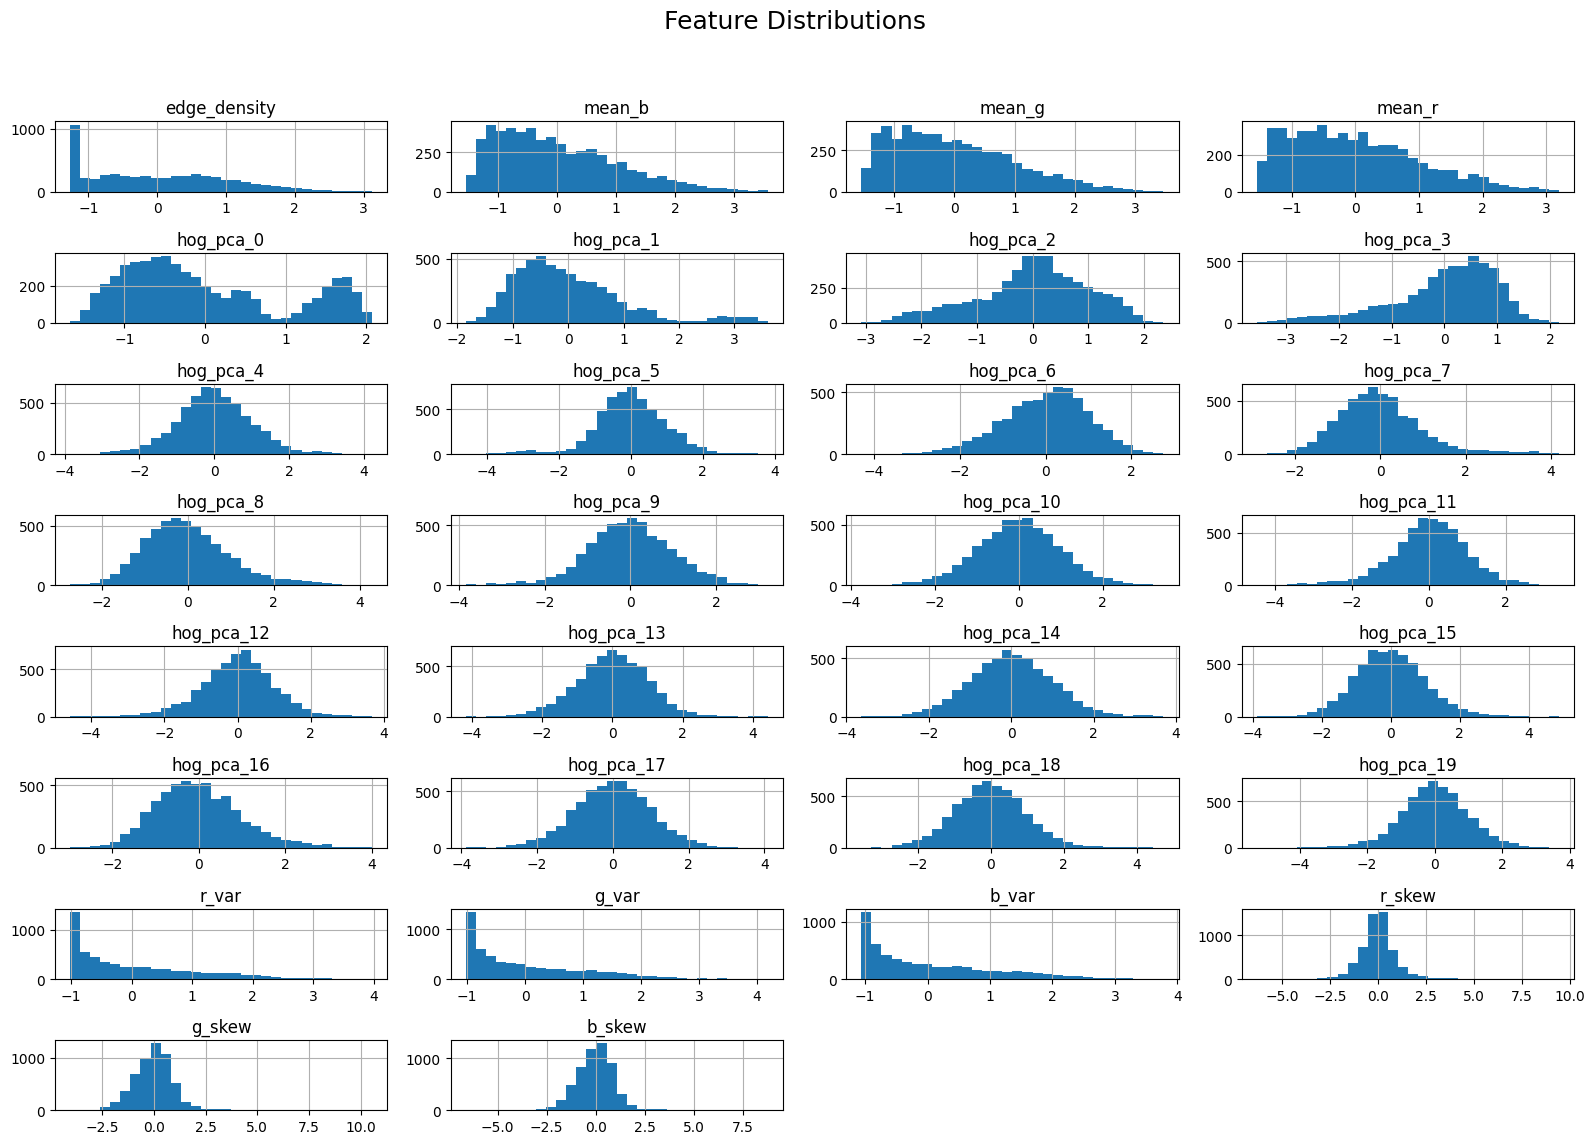

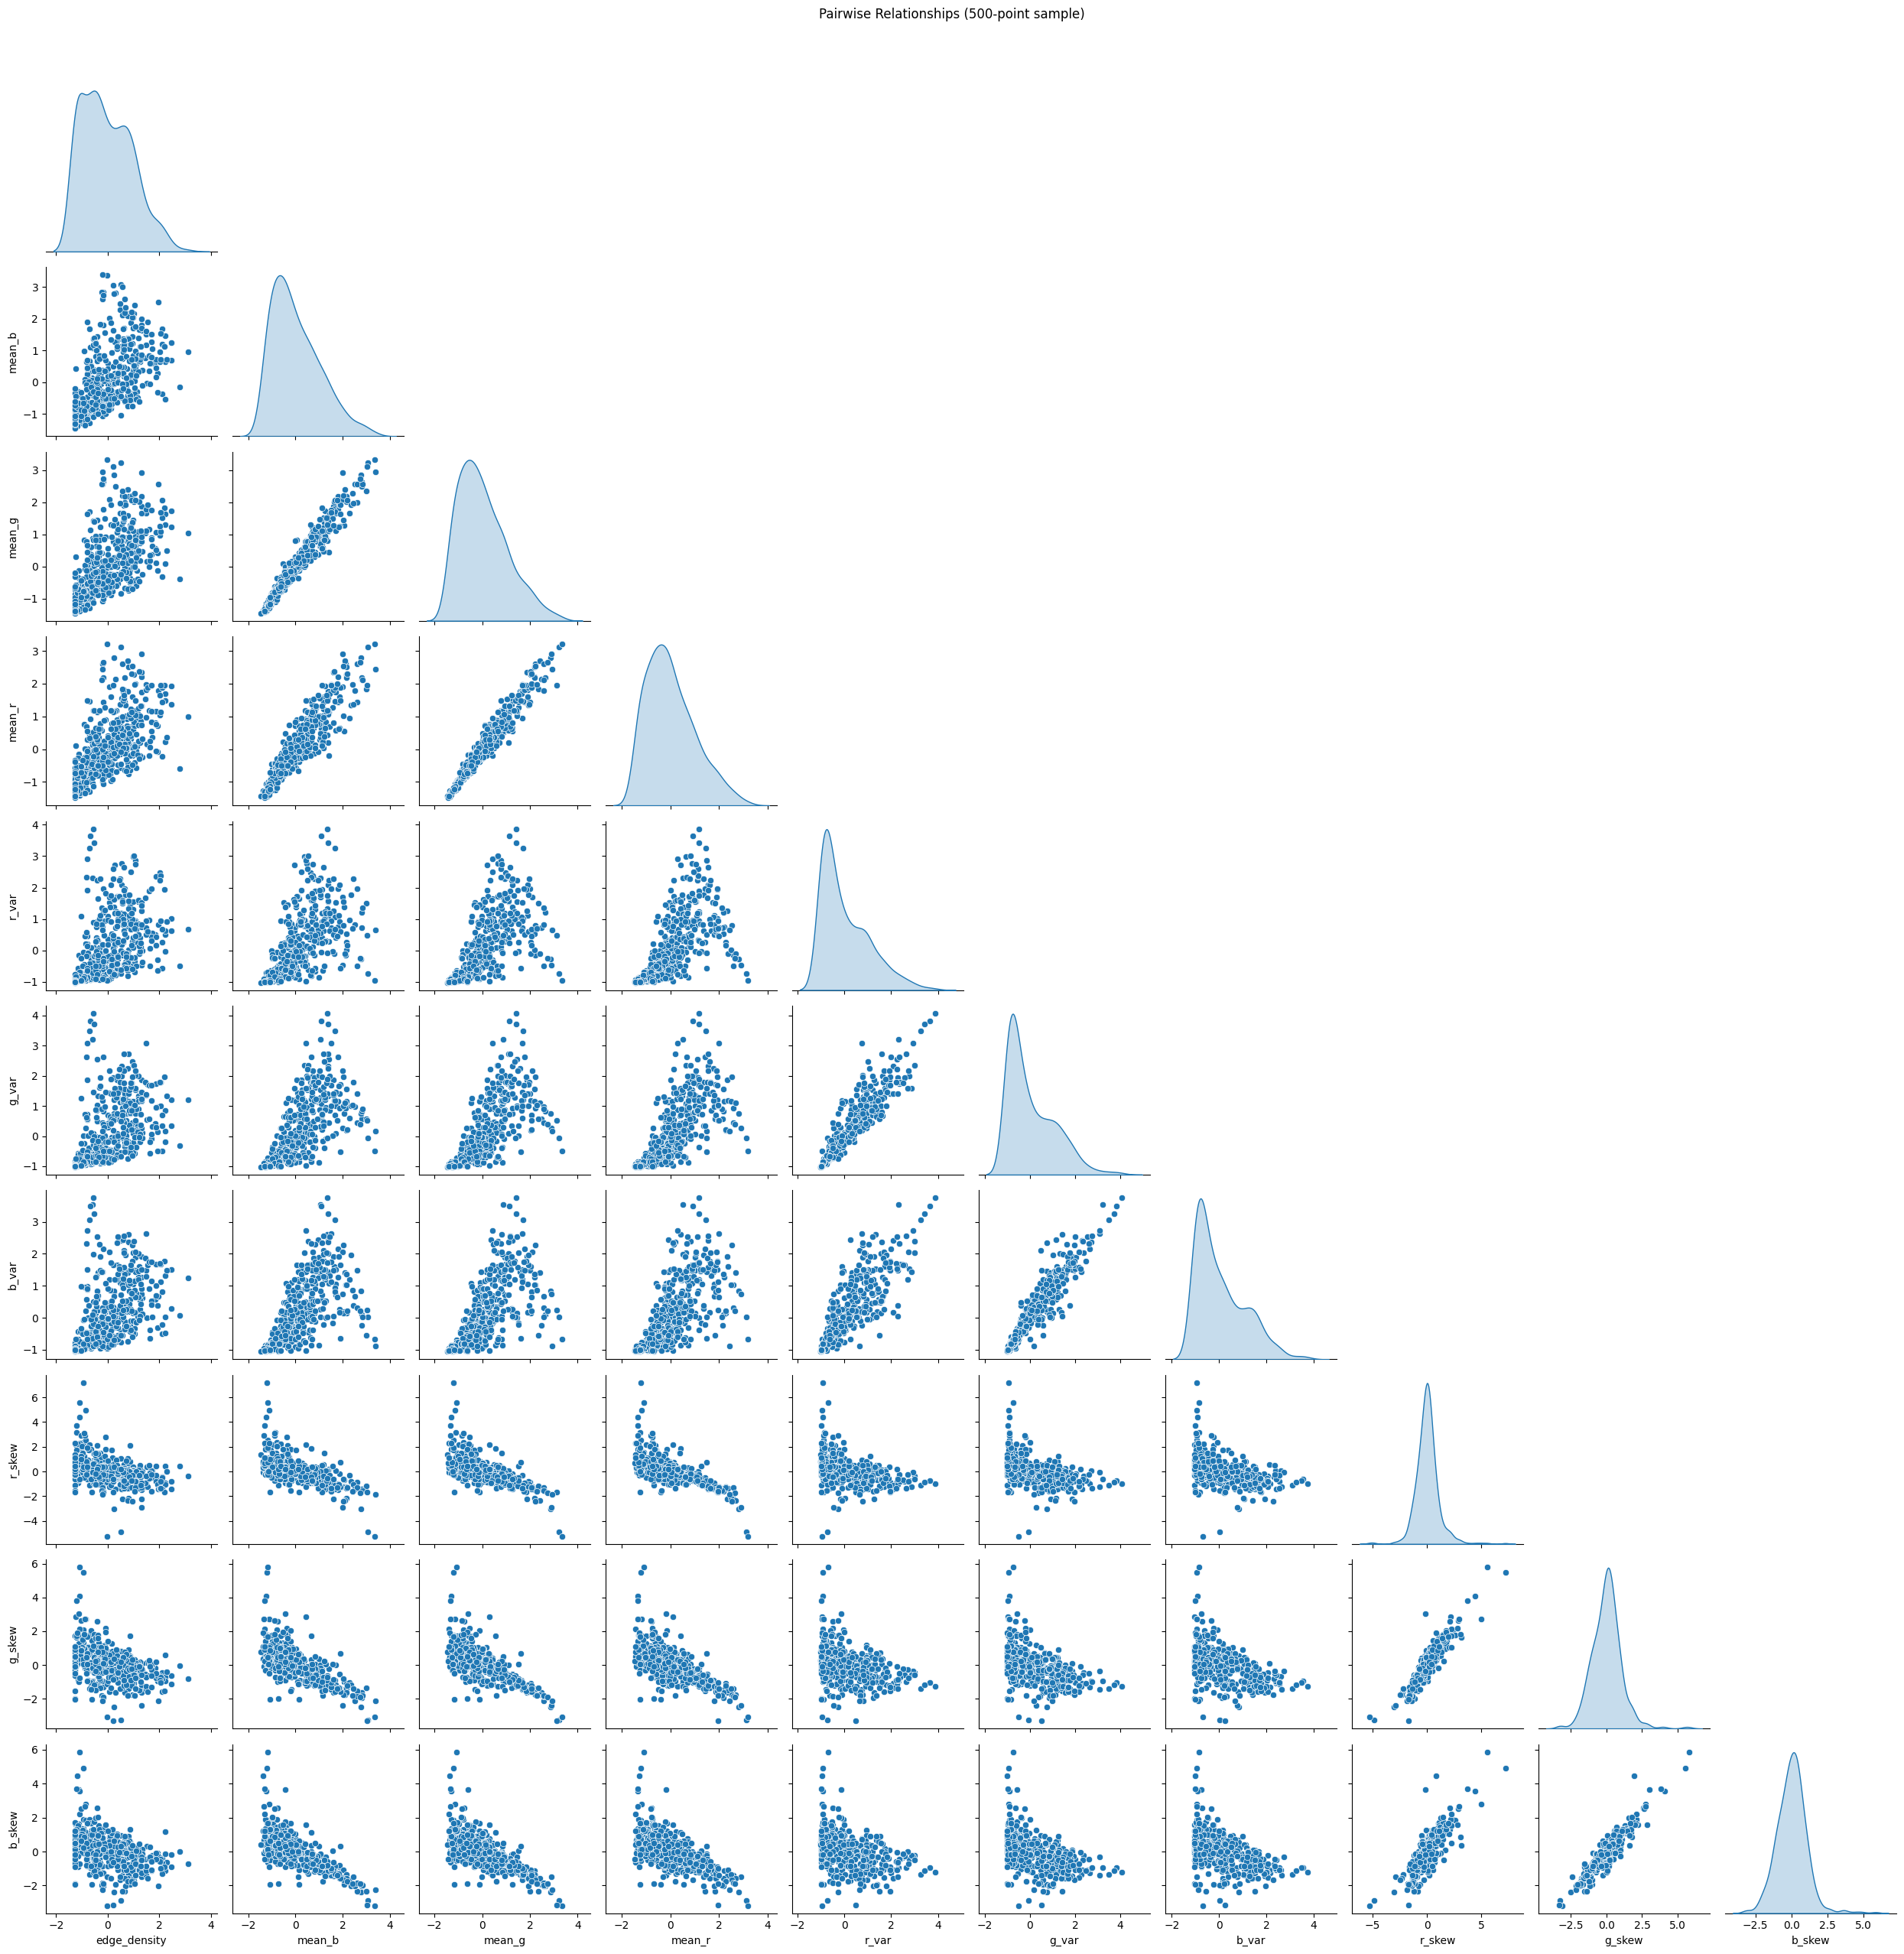

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

hog_cols = [c for c in train_df.columns if c.startswith('hog_pca')]
eda_feats = (
    ['edge_density', 'mean_b', 'mean_g', 'mean_r'] +
    hog_cols +
    ['r_var', 'g_var', 'b_var', 'r_skew', 'g_skew', 'b_skew']
)

eda_df = scaled_train_df[eda_feats]

# 3. Plot distributions for each feature
plt.figure(figsize=(16, 12))
eda_df.hist(bins=30, layout=(len(eda_feats) // 4 + 1, 4), figsize=(16, 12))
plt.suptitle("Feature Distributions", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

scatter_df = eda_df.drop(hog_cols, axis = 1) # helps clean up the visualization

#  Sampled scatter‑matrix 
sampled = scatter_df.sample(n=500, random_state=42) # some features are vaguelly linear, logistic regression should be good

sns.pairplot(sampled, diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships (500‑point sample)", y=1.02)
plt.tight_layout()
plt.show()

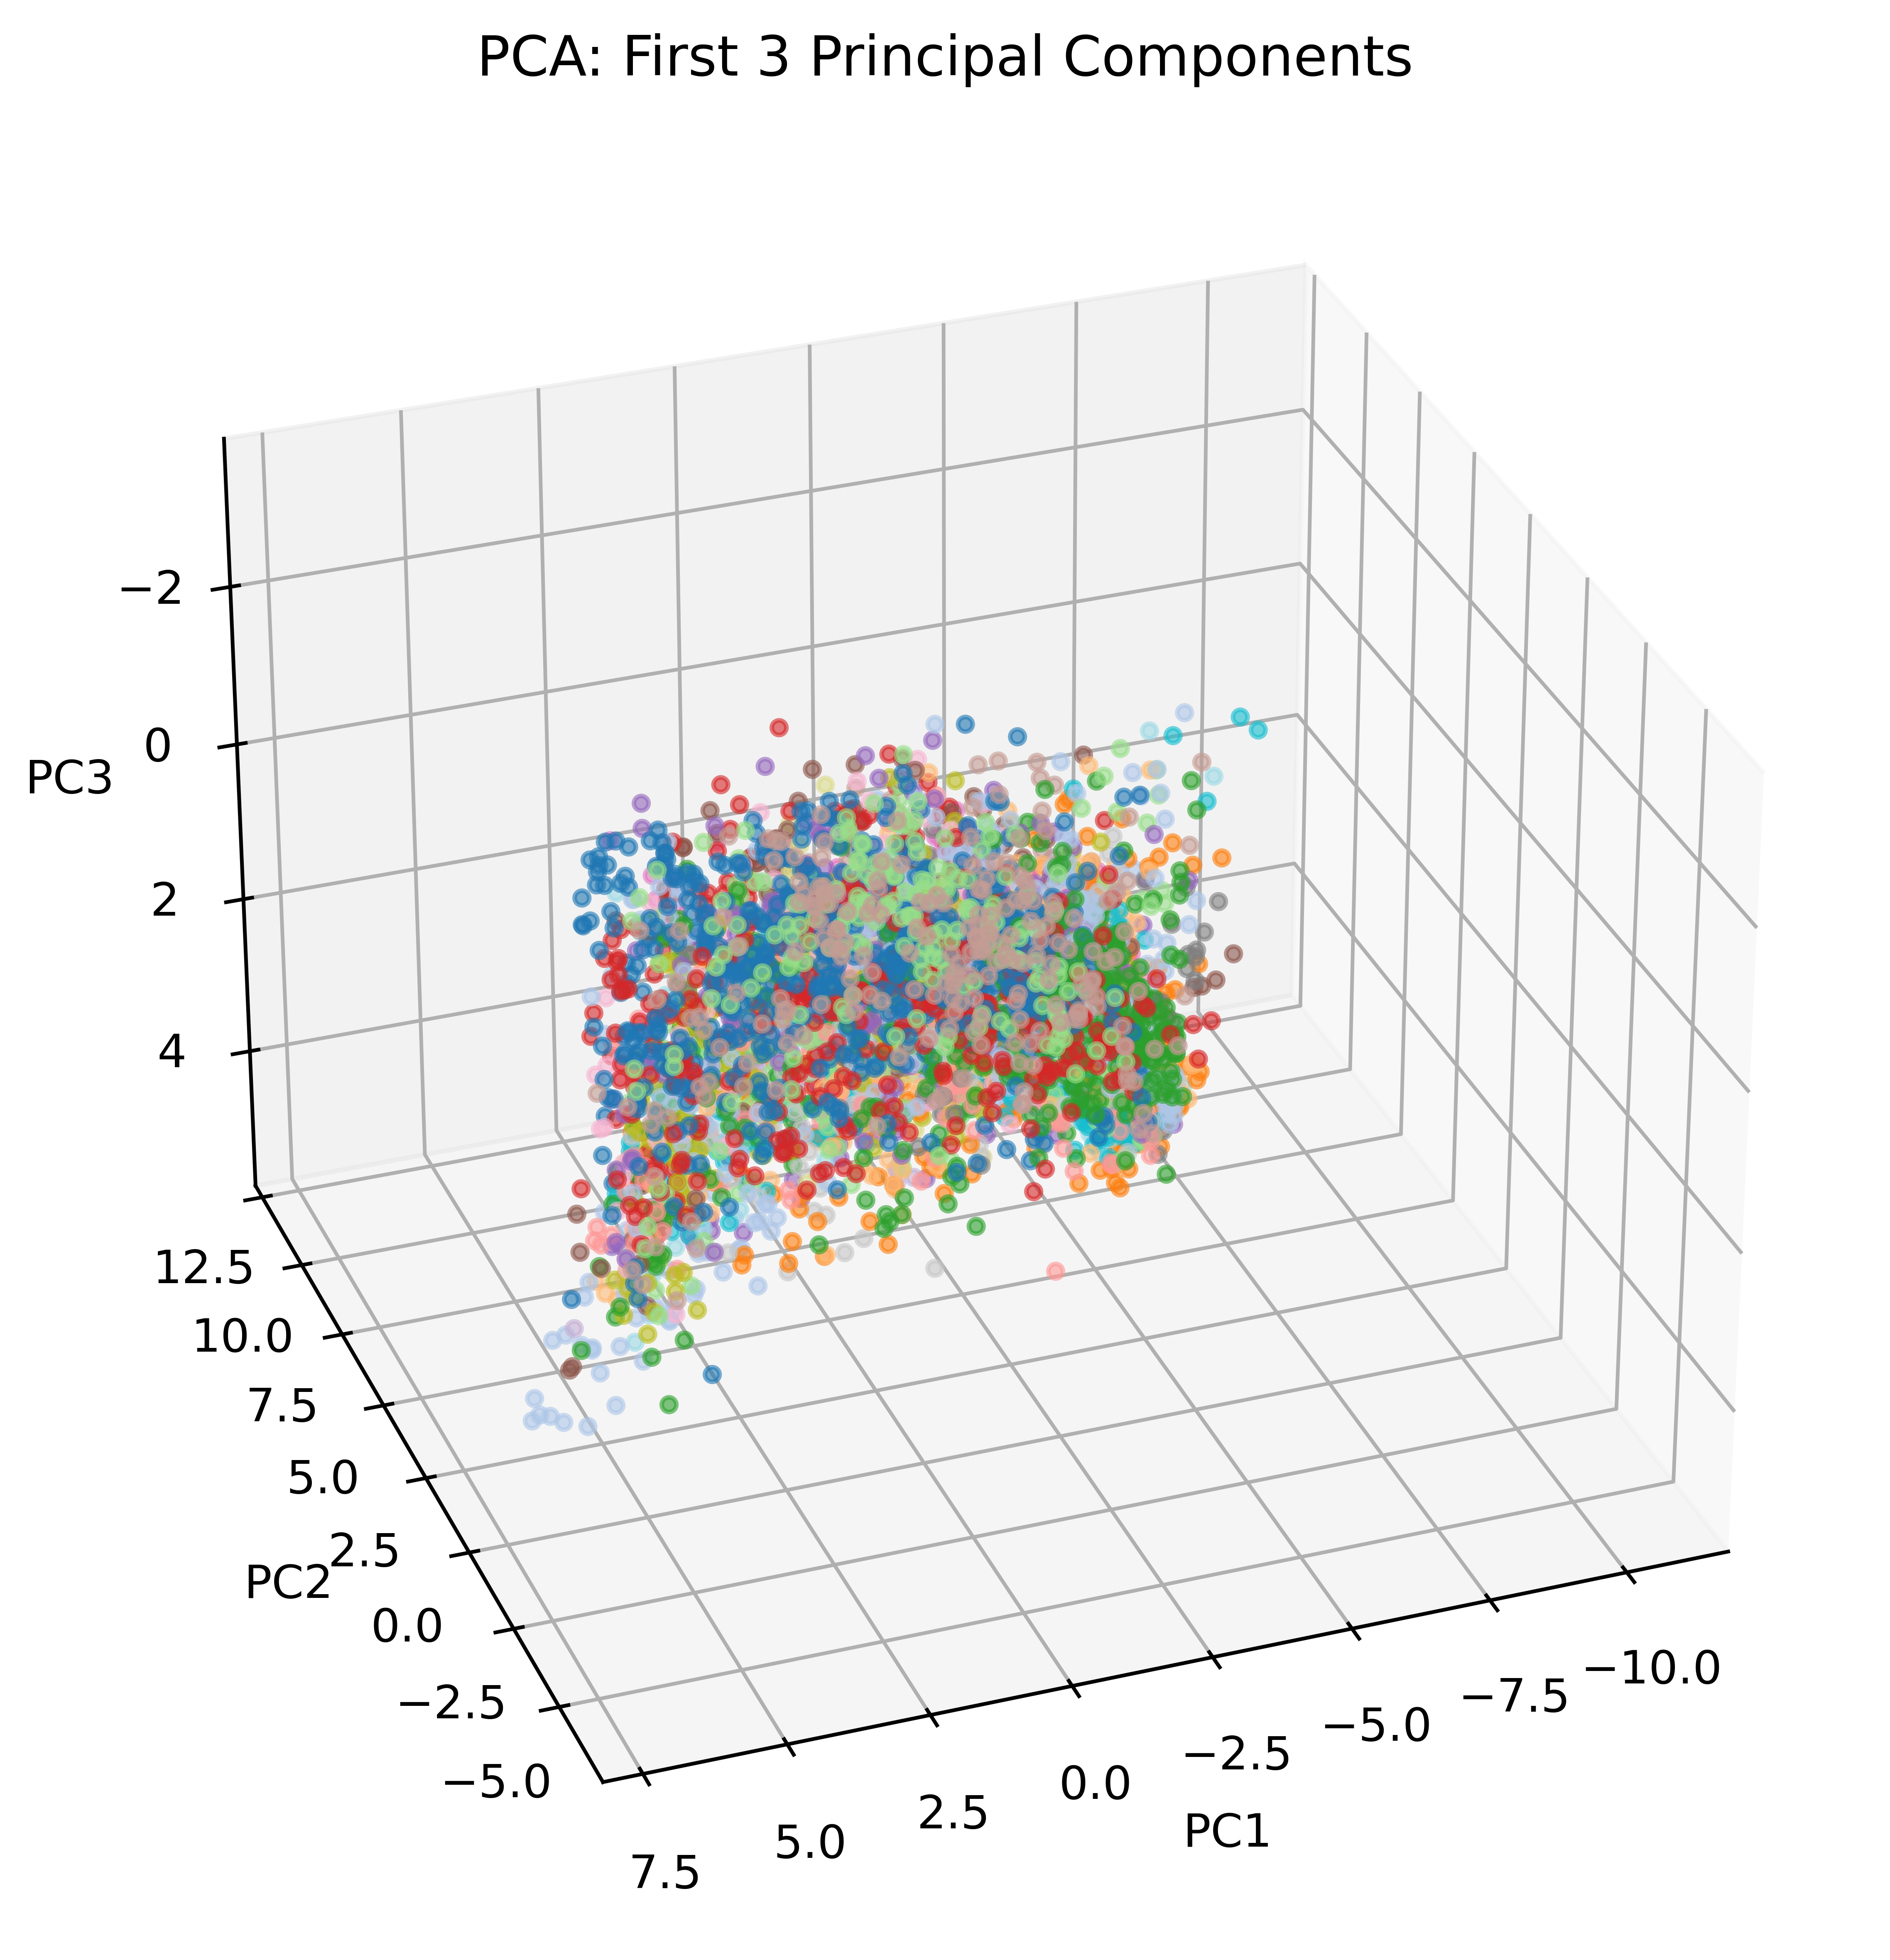

In [310]:
# as it is very vague clusters if you can call it that, feature selection needed fs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np

# Assuming eda_df and train_df["ClassId"] are aligned and eda_df is numeric
X_reduced = PCA(n_components=3).fit_transform(eda_df)
y = train_df["ClassId"].values

# Set up figure
fig = plt.figure(figsize=(8, 6), dpi=800)
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

# Get unique classes and colors
classes = np.unique(y)
colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))

# Plot each class separately for clean legend
for cls, color in zip(classes, colors):
    idx = y == cls
    ax.scatter(
        X_reduced[idx, 0],
        X_reduced[idx, 1],
        X_reduced[idx, 2],
        label=str(cls),
        color=color,
        s=10,
        alpha=0.6
    )

ax.set_title("PCA: First 3 Principal Components")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.tight_layout()
plt.show()


# Training Machine learning models

## SVM

In [311]:
from sklearn import metrics
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score


clf = SVC(kernel="linear") # Try linear kernel for now then others

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_val)
accuracy_score(y_pred, y_val)

0.8269581056466302

In [312]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV
from scipy.stats import loguniform
from sklearn.svm import SVC
# Randomized search for a broad region
rnd = RandomizedSearchCV(
    SVC(),
    param_distributions={
        'C': loguniform(1e-1, 1e2),
        'gamma': loguniform(1e-4, 1),
        'kernel': ['linear', 'sigmoid']
    },
    n_iter=10,
    n_jobs=-1,
    random_state=42,
    verbose=2
)
rnd.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=sigmoid; total time=   0.6s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=sigmoid; total time=   0.7s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=sigmoid; total time=   0.6s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=sigmoid; total time=   0.7s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=sigmoid; total time=   0.6s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   0.8s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   0.8s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   0.9s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   0.9s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   1.0s
[CV] END C=1.0

RandomizedSearchCV(estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1687ad550>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x306362850>,
                                        'kernel': ['linear', 'sigmoid']},
                   random_state=42, verbose=2)

In [313]:
# Focused halving search around the best found
best = rnd.best_params_
grid_fine = {
    'C': [best['C'] * f for f in [0.5, 1, 2]],
    'gamma': [best['gamma'] * f for f in [0.5, 1, 2]],
    'kernel': ['linear']
}

In [314]:
halving = HalvingGridSearchCV(
    SVC(),
    grid_fine,
    factor=2,
    resource='n_samples',
    max_resources='auto',
    n_jobs=-1,
    verbose=2
)
halving.fit(X_train, y_train)

print("Final best params:", halving.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 617
max_resources_: 4939
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 617
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END C=0.05250116252115674, gamma=6.18329126506542e-05, kernel=linear; total time=   0.0s
[CV] END C=0.05250116252115674, gamma=6.18329126506542e-05, kernel=linear; total time=   0.0s
[CV] END C=0.05250116252115674, gamma=6.18329126506542e-05, kernel=linear; total time=   0.0s
[CV] END C=0.05250116252115674, gamma=6.18329126506542e-05, kernel=linear; total time=   0.0s
[CV] END C=0.05250116252115674, gamma=0.0001236658253013084, kernel=linear; total time=   0.0s
[CV] END C=0.05250116252115674, gamma=6.18329126506542e-05, kernel=linear; total time=   0.0s
[CV] END C=0.05250116252115674, gamma=0.0001236658253013084, kernel=linear; total time=   0.0s
[CV] END C=0.05250116252115674, gamma=0.0001236658253013084, kernel=linear; total

In [315]:
y_pred = halving.best_estimator_.predict(X_val)

print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.83      0.79      0.81        24
           2       0.76      0.76      0.76        34
           3       0.65      0.69      0.67        16
           4       0.72      0.79      0.75        29
           5       0.70      0.70      0.70        30
           6       0.60      1.00      0.75         3
           7       0.86      0.69      0.77        26
           8       0.69      0.79      0.73        14
           9       0.81      1.00      0.90        13
          10       0.91      0.91      0.91        35
          11       0.53      0.90      0.67        10
          12       1.00      1.00      1.00        29
          13       1.00      1.00      1.00        26
          14       0.93      1.00      0.97        14
          15       1.00      0.71      0.83         7
          16       1.00      1.00      1.00         5
          17       1.00    

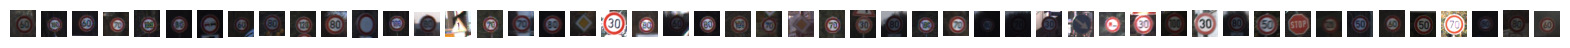

1877     3
4733     7
2942     3
5025     4
5310     7
1377     5
1137     9
648      3
1789     5
4845     8
166      5
3823    15
2274     7
682      5
3216    18
1208     4
4269     4
1902     5
2978    12
2863     1
2609     5
2958     3
3641     5
1175     7
4988     4
2198    12
4064     4
3636     1
2513     5
1573     7
4802     4
518      5
691      4
5237     1
5365    38
364     10
1742     1
4013     7
356      1
4328     5
2593     2
3108    14
4882     8
1218     2
4645     3
2648     2
1284     4
5375     5
5134     5
1028     3
Name: ClassId, dtype: int64

In [316]:
from skimage import io
import matplotlib.pyplot as plt

dists = [(i, val) for i, val in enumerate(np.sum(halving.decision_function(X_train), axis=1))]
dists.sort(key=lambda x: x[1], reverse=False)
fig, ax = plt.subplots(ncols=50, figsize=(20, 2))

worst_indx = [i for i, val in dists[:50]]
vals = X_train.iloc[worst_indx].index

for i, pth in enumerate(train_df.iloc[vals]["image_path"]):
    myimg = io.imread(pth)
    ax[i].imshow(myimg)
    ax[i].axis('off')

plt.show()

y_train[vals]


# Logistic Regression

In [317]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=10000)


clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
accuracy_score(y_pred, y_val)

0.8233151183970856

In [318]:
# logistic regression with l1 regularization

clf = LogisticRegression(max_iter=10000, penalty='l2')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
accuracy_score(y_pred, y_val)

0.8233151183970856

# Feature engineering

In [319]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train, y_train)


In [320]:
MI_cols = X_train.columns[mi_scores > 0.2]
MI_train = X_train[X_train.columns[mi_scores > 0.2]]

In [321]:
mi_scores

array([0.01043794, 0.19448036, 0.24585905, 0.24102604, 0.25907519,
       0.88508498, 0.54171774, 0.50766243, 0.79974379, 0.33760973,
       0.37356465, 0.16564925, 0.2646087 , 0.3253206 , 0.23673116,
       0.18408843, 0.20865384, 0.3239335 , 0.07196089, 0.10498577,
       0.101603  , 0.11005934, 0.13719216, 0.19652459, 0.13225646,
       0.22904564, 0.20170466, 0.16767538, 0.29792857, 0.12728717,
       0.17933201, 0.14681227, 0.16371817, 0.15738108, 0.16333167,
       0.25355169, 0.17647192, 0.12902204, 0.09162406, 0.2141279 ,
       0.19951173, 0.13000649, 0.23373948, 0.13309682, 0.14632188,
       0.11318782, 0.1121272 , 0.12517103, 0.1999896 , 0.1860654 ,
       0.09468496, 0.19237265, 0.1198841 , 0.09801931, 0.15258389,
       0.14183183, 0.14449436, 0.14079173, 0.14985661, 0.11156337,
       0.22683057, 0.23759329, 0.20098845, 0.15957982, 0.172815  ,
       0.18799557, 0.1400544 , 0.10330406, 0.08138807, 0.09809295,
       0.09494936, 0.10483282, 0.11481632, 0.07965983, 0.10364